In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive/My Drive/keras-u-net-master

/content/drive/My Drive/keras-u-net-master


In [4]:
from __future__ import print_function

import os
import numpy as np

from skimage.io import imsave, imread
from PIL import Image
data_path = 'data/'

image_rows = 512
image_cols = 512


def create_train_data():
    train_data_path = os.path.join(data_path, 'train/Image PP/')
    train_data_Label_path = os.path.join(data_path, 'train/Label/')
    images = os.listdir(train_data_path)
    total = len(images)

    imgs = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)
    imgs_mask = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    for image_name in images:
        img = imread(os.path.join(train_data_path, image_name), as_gray=True)
        img_mask = imread(os.path.join(train_data_Label_path, image_name), as_gray=True)

        img = np.array([img])
        img_mask = np.array([img_mask])

        imgs[i] = img
        imgs_mask[i] = img_mask

        if i % 50 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save('imgs_train.npy', imgs)
    np.save('imgs_mask_train.npy', imgs_mask)
    print('Saving to .npy files done.')


def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    imgs_mask_train = np.load('imgs_mask_train.npy')
    return imgs_train, imgs_mask_train


def create_test_data():
    train_data_path = os.path.join(data_path, 'test/Image PP')
    images = os.listdir(train_data_path)
    total = len(images)

    imgs = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)
    imgs_id = np.ndarray((total, ), dtype=np.int32)

    i = 0
    print('-'*30)
    print('Creating test images...')
    print('-'*30)
    for image_name in images:
        img_id = int(image_name.split('.')[0])
        img = imread(os.path.join(train_data_path, image_name), as_gray=True)

        img = np.array([img])

        imgs[i] = img
        imgs_id[i] = img_id

        if i % 10 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save('imgs_test.npy', imgs)
    np.save('imgs_id_test.npy', imgs_id)
    print('Saving to .npy files done.')

def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    imgs_id = np.load('imgs_id_test.npy')
    return imgs_test, imgs_id

if __name__ == '__main__':
    create_train_data()
    create_test_data()

------------------------------
Creating training images...
------------------------------
Done: 0/150 images
Done: 50/150 images
Done: 100/150 images
Loading done.
Saving to .npy files done.
------------------------------
Creating test images...
------------------------------
Done: 0/60 images
Done: 10/60 images
Done: 20/60 images
Done: 30/60 images
Done: 40/60 images
Done: 50/60 images
Loading done.
Saving to .npy files done.


Loading and preprocessing train data...
Fitting model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 120 samples, validate on 30 samples
Epoch 1/1000
120/120 [==============================] - 15s 125ms/step - loss: 0.6660 - dice_coef: 0.1188 - acc: 0.9209 - mean_io_u: 0.4701 - mean_absolute_error: 0.4861 - val_loss: 0.6625 - val_dice_coef: 0.1256 - val_acc: 0.9244 - val_mean_io_u: 0.4668 - val_mean_absolute_error: 0.4842
Epoch 2/1000
120/120 [==============================] - 5s 43ms/step - loss: 0.6535 - dice_coef: 0.1184 - acc: 0.9294 - mean_io_u: 0.4669 - mean_absolute_error: 0.4795 - val_loss: 0.6560 - val_dice_coef: 0.1256 - val_acc: 0.9267 - val_mean_io_u: 0.4669 - val_mean_absolute_error: 0.4808
Epoch 3/1000
120/120 [==============================] - 5s 43ms/step - loss: 0.6414 - dice_coef: 0.1188 - acc: 0.9314 - mean_io_u: 0.4670 - mean_absolute_error: 0.4730 - val_loss: 0.6494 - val_dice_coef: 0.1257 - val_acc: 0.9275 - val_mean_io_u: 0.4670 - val_mean_absolute_error: 0.4772
Epoch 4/1000
120/120 [==============================] - 5s 43ms/step - loss: 0.6287 - dice_c

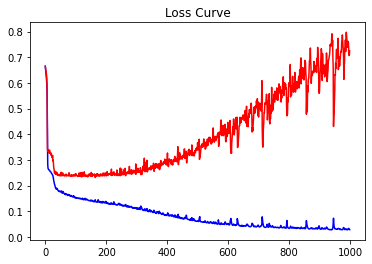

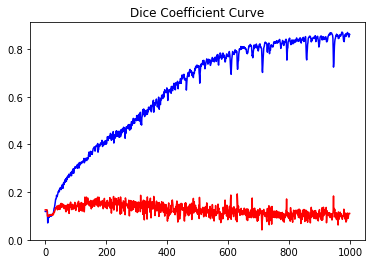

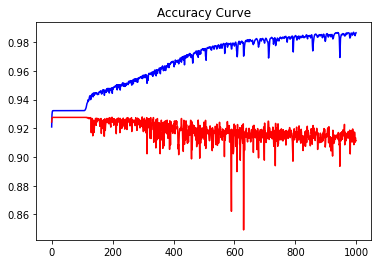

In [5]:
from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import losses,metrics
import tensorflow as tf

from data_preparation import load_train_data, load_test_data

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 512
img_cols = 512

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return dice_coef(y_true, y_pred)


def get_unet(pretrained_weights=None):
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[dice_coef,'acc', tf.keras.metrics.MeanIoU(num_classes=2),metrics.mae])
    #model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[metrics.binary_accuracy,keras_metrics.binary_precision(),keras_metrics.binary_recall()])
    #model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p


def train_and_predict():
    print('Loading and preprocessing train data...')
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    #model = get_unet('unet_weights_150_Img_PP.h5') #If you are training again, use this line to load the pre-training model
    model = get_unet()

    model_checkpoint = ModelCheckpoint('unet_weights_150_Img_PP.h5', monitor='val_loss', save_best_only=True)
    print('Fitting model...')
    hist=model.fit(imgs_train, imgs_mask_train, batch_size=8, nb_epoch=1000, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])
    print(model.summary())

    imgs_test, imgs_id_test = load_test_data()
    imgs_test = preprocess(imgs_test)
    imgs_test = imgs_test.astype('float32')
    mean=np.mean(imgs_test)
    std=np.std(imgs_test)
    imgs_test -= mean
    imgs_test /= std

    model.load_weights('unet_weights_150_Img_PP.h5')

    print('Predicting masks on test data...')

    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    pred_dir = 'preds_UNet'

    if not os.path.exists(pred_dir):
      os.mkdir(pred_dir)

    for image, image_id in zip(imgs_mask_test, imgs_id_test):
      image = (image[:, :, 0] * 255.).astype(np.uint8)
      imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)
    
    import matplotlib.pyplot as plt
    import pickle
    model.load_weights('unet_weights_150_Img_PP.h5')
    
    l_u=plt.plot(hist.history['loss'], color='b')
    vl_u=plt.plot(hist.history['val_loss'], color='r')
    plt.title('Loss Curve')
    pickle.dump(l_u, open('Loss_UN.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`
    pickle.dump(vl_u, open('Val_Loss_UN.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`
    plt.show()

    d_u=plt.plot(hist.history['dice_coef'], color='b')
    vd_u=plt.plot(hist.history['val_dice_coef'], color='r')
    plt.title('Dice Coefficient Curve')
    pickle.dump(d_u, open('Dice_UN.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`
    pickle.dump(vd_u, open('Val_Dice_UN.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`
    plt.show()

    a_u=plt.plot(hist.history['acc'], color='b')
    va_u=plt.plot(hist.history['val_acc'], color='r')
    plt.title('Accuracy Curve')
    pickle.dump(a_u, open('Acc_UN.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`
    pickle.dump(va_u, open('Val_Acc_UN.fig.pickle', 'wb')) # This is for Python 3 - py2 may need `file` instead of `open`
    plt.show()

if __name__ == '__main__':
    train_and_predict()

In [0]:
!pip install keras-metrics

In [0]:
import keras as K
print(K.__version__)

2.3.1


In [0]:
import matplotlib.pyplot as plt

model.load_weights('unet_weights_150_Img.h5')
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

plt.plot(hist.history['mean_i_ou_7'], color='b')
plt.plot(hist.history['val_mean_i_ou_7'], color='r')
plt.show()

NameError: ignored